In [1]:
# --- Importing Libraries
import sys
print("Python Executable:", sys.executable)

import pandas as pd # type: ignore
import numpy as np
np.int = int # 😠 come on pygam
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import statsmodels.api as sm # type: ignore
import statsmodels.formula.api as smf # type: ignore
import matplotlib.pyplot as plt # type: ignore
from stargazer.stargazer import Stargazer # type: ignore
from IPython.display import HTML, display # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import polars as pl # type: ignore
import re
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
from pygam import LinearGAM, s
#Hacking together version deprecationsin pygam
import scipy.sparse
scipy.sparse.csr.csr_matrix.A = property(lambda self: self.toarray())


Python Executable: c:\Users\ben.pharris\Documents\FunctionalEstimation\venvFunctionalFormEstimation\Scripts\python.exe


C:\Users\ben.pharris\AppData\Local\Temp\ipykernel_71668\2812491694.py:26: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.sparse.csr.csr_matrix.A = property(lambda self: self.toarray())


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

dates = pd.date_range(start="2022-01-01", periods=1000, freq="D")

# Sales Data
store_sales = np.random.normal(loc=4500, scale=500, size=1000).clip(3000, 6000)
web_sales = np.random.normal(loc=3500, scale=600, size=1000).clip(2000, 5000)

# Traffic Data
store_traffic = np.random.normal(loc=5000, scale=1000, size=1000).clip(2000, 8000)
web_traffic = np.random.normal(loc=2_000_000, scale=1_000_000, size=1000).clip(500_000, 5_000_000)

# Create a dataframe
df = pd.DataFrame({
    'date': dates,
    'store_sales': store_sales.astype(int),
    'web_sales': web_sales.astype(int),
    'store_traffic': store_traffic.astype(int),
    'web_traffic': web_traffic.astype(int)
})

print(df.describe())

                      date  store_sales    web_sales  store_traffic  \
count                 1000  1000.000000  1000.000000    1000.000000   
mean   2023-05-15 12:00:00  4508.818000  3542.345000    5004.315000   
min    2022-01-01 00:00:00  3000.000000  2000.000000    2000.000000   
25%    2022-09-07 18:00:00  4175.500000  3135.750000    4351.500000   
50%    2023-05-15 12:00:00  4512.500000  3537.500000    4999.500000   
75%    2024-01-20 06:00:00  4823.250000  3936.750000    5660.500000   
max    2024-09-26 00:00:00  6000.000000  5000.000000    8000.000000   
std                    NaN   487.605414   591.612191     979.795781   

        web_traffic  
count  1.000000e+03  
mean   2.014329e+06  
min    5.000000e+05  
25%    1.262579e+06  
50%    2.000184e+06  
75%    2.666945e+06  
max    5.000000e+06  
std    9.639913e+05  


In [ ]:
sns.set(style="whitegrid")

# Variables to plot (excluding Date)
variables = ['store_sales', 'web_sales', 'store_traffic', 'web_traffic']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(data=df, x=var, kde=True, ax=axes[i], bins=30, color='steelblue')
    axes[i].set_title(f"Distribution of {var.replace('_', ' ').title()}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [3]:
scaler = StandardScaler()

# Select the columns to scale (excluding 'Date')
outcome_vars = ['store_sales', 'web_sales', 'store_traffic', 'web_traffic']

# Fit and transform the data
df_scaled = df.copy()
df_scaled[outcome_vars] = scaler.fit_transform(df[outcome_vars])

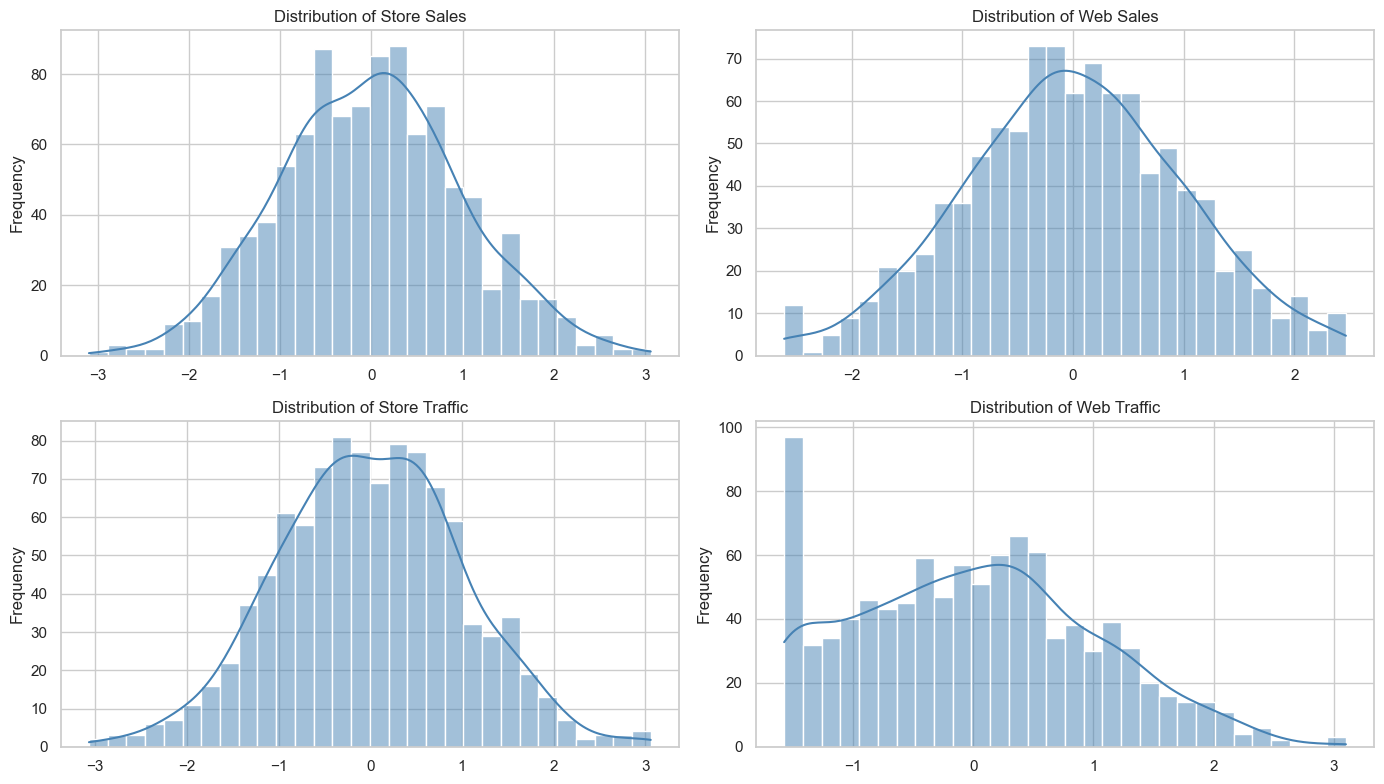

In [4]:
#Scaled Plots
sns.set(style="whitegrid")

# Variables to plot (excluding Date)
variables = ['store_sales', 'web_sales', 'store_traffic', 'web_traffic']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(data=df_scaled, x=var, kde=True, ax=axes[i], bins=30, color='steelblue')
    axes[i].set_title(f"Distribution of {var.replace('_', ' ').title()}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [6]:
df['traffic'] = df['web_traffic'] + df['store_traffic']
df_scaled['traffic'] = df_scaled['web_traffic'] + df_scaled['store_traffic']

scaler_traffic = StandardScaler()
df_scaled['total_traffic'] = scaler_traffic.fit_transform(df[['traffic']])


In [ ]:
df['web_conversion'] = df['web_sales'] / df['web_traffic']

df['store_conversion'] = df['store_sales'] / df['store_traffic']

In [9]:
# Set random seed for reproducibility
np.random.seed(123)

# Define the ranges you want
predictor_specs = [
    (2000, 5000),        # x1
    (5000, 10000),       # x2
    (10000, 25000),      # x3
    (25000, 50000),      # x4
    (50000, 100000),     # x5
    (100000, 200000),    # x6
    (200000, 500000),    # x7
    (500000, 1000000),   # x8
]

# Generate predictors with noise
for i, (low, high) in enumerate(predictor_specs):
    df[f'x{i+1}'] = np.random.uniform(low, high, size=len(df))

In [10]:
variables = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
scaler_predictors = StandardScaler()

for var in variables:
    df_scaled[var] = scaler_predictors.fit_transform(df[[var]])

In [13]:
a = smf.ols("traffic ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8", data = df).fit(cov_type='HC1')
b = smf.ols("traffic ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8", data = df_scaled).fit(cov_type='HC1')
c = smf.ols("total_traffic ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8", data = df_scaled).fit(cov_type='HC1')

stargazer = Stargazer([a,b,c])
html_output = stargazer.render_html()
display(HTML(html_output))